## Introduction to colab

Welcome to this python introduction session! Today we will learn some of the basics of image processing and segmentation using Python. For this course we will use **Google Colab**. Using Colab, there is no need to install Python and all the other libraries locally on your PC because all the codes are executed on computers hosted by Google. This makes it very easy to get started with python programming.

In this lab, we will be using a notebook set up. This means we can have a combination of plain text, images and code in a single file! We can also execute cells of code seperately, so that we don't need to run the whole script from the beginning each time we make changes in some part of the code. 

While not needed for this assignment, should you wish to install a Python environment on your own PC (local), here is a link that explains how to do so: [link](https://www.youtube.com/watch?v=WUeBzT43JyY).

The notebook consists of cells that contain Python code, like the one below. To run a cell you have two options:
- Hover your mouse above a cell and press the triangle/arrow on the left of the cell,
- Click inside the cell and press ctrl + enter

Try it out on the cell below! (note that running your first cell may take a few seconds because the connection to Google needs te be established)

In [1]:
print('Hello world!!')

Hello world!!


## The segmentation task

We will be working with CT images of 3D printed metal. A big issue with this type of 3D printed metal is that small air bubbles or *pores* develop within the metal, weakening the metal object. Our goal is to segment these pores from the CT images such that they can be analyzed further and the 3D printing can be improved. Here is a 2D slice of a 3D CT image of the 3D printed metal:

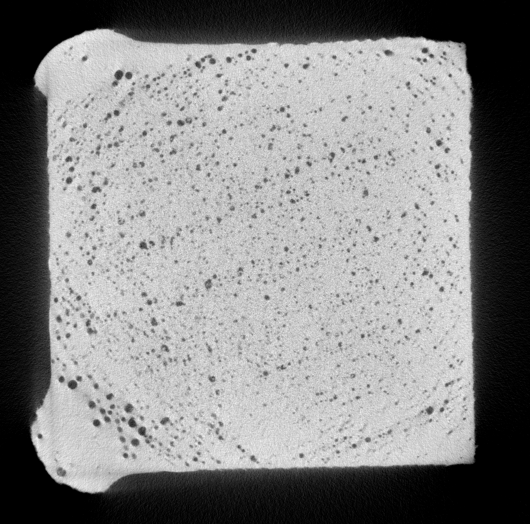

## Notebook setup

From now on, each time you reach a code-cell, you can go ahead and run it. However, some cells will contain incomplete code and you will need to fill in the missing lines. These cells will probably return an error if you haven't filled them in yet. If you have forgotten to run a cell or have made a coding mistake, cells below it might not work! So be sure to run cells in the correct order after having correctly filled in code where you need to!

So go ahead, run the cell below. The contents of this cell will be made clear later in this session.

In [2]:
from skimage import io, data, filters
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.segmentation import flood, flood_fill
import cv2 as cv
from scipy.cluster.vq import kmeans, vq

### Mount the google drive folder 

To have access to the data from within this notebook, you first need to open up your google drive. In the "shared with me" folder you should see a folder called **dataset_doctoral_schools**. Right click on this folder, then choose "add shortcut to drive" and click on the option "My Drive". 

Having done that, you can go ahead and run the cell below. You will get a pop up asking permission for colab to access this data. Be sure to give this permission!

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# To have access to the data from this notebook
# Go to your google drive -> shared with me 
# Right click on the dataset (dataset_doctoral_schools) -> add shortcut to drive
# Choose the option My Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset that was shared with you contains a file calld **labels.tif** and a subdirectory called **images**.



The subdirectory **images** contains numerous files with the name **slice_X.tif**. Each file contains a single 2D image slice from the 3D volume, where X is the index of the corresponding slice. For example, the file with name slice_10.tif, corresponds to the the slice at index 10. 

The file **labels.tif** contains a single 3D image. The first dimension of this image corresponds to the slice index (X) and the remaining 2D image per slice index is a binary image of the same size as the slice_X.tif files.

So for example, if we want the label slice corresponding to our image file slice_10.tif, we need to take the 10th 2D image in the 3D labels.tif file. 



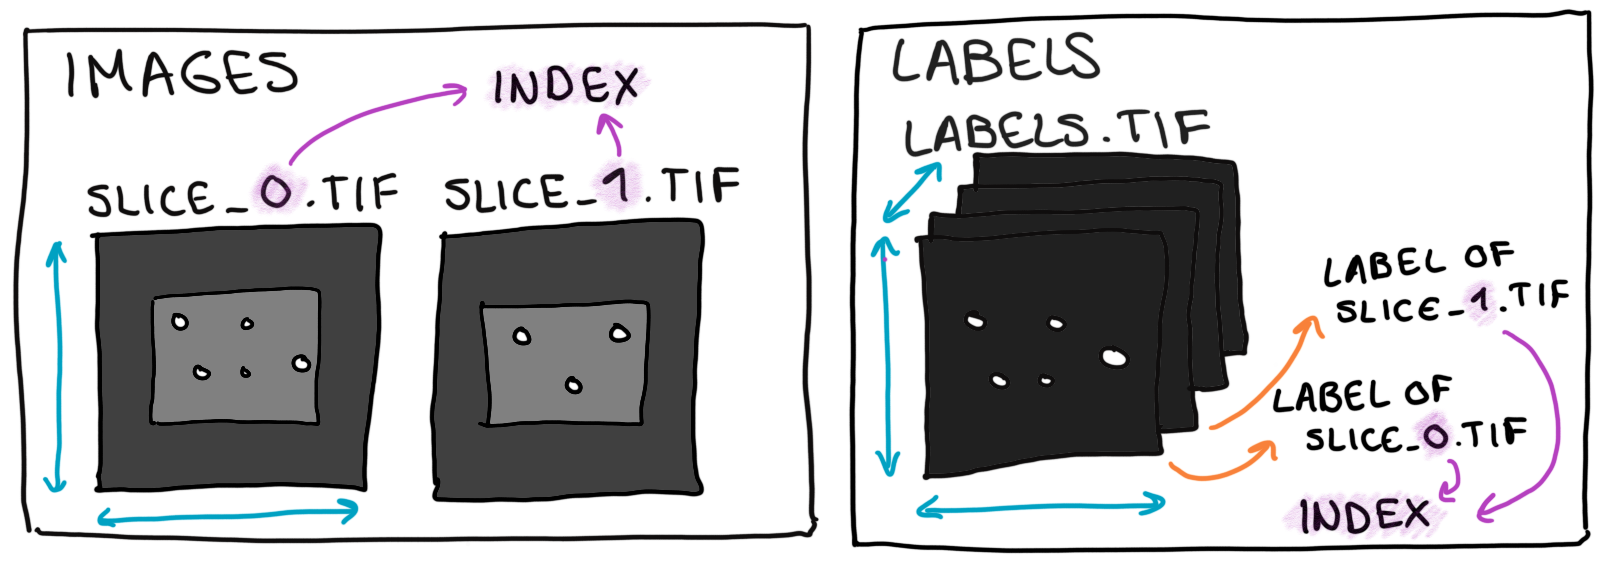

### What is an image?

An image consists of pixels. In a grayscale image (like our input images), each pixel contains one value: the intensity value. As a convention, we will consider these values to be scaled between between 0 and 1, with 0 being black (the lowest possible intensity value in the file) and 1 being white (the highest possible intensity value in the file). So the lower the intensity of a pixel, the darker it will look. A very simple example of a grayscale 2D image is given below:







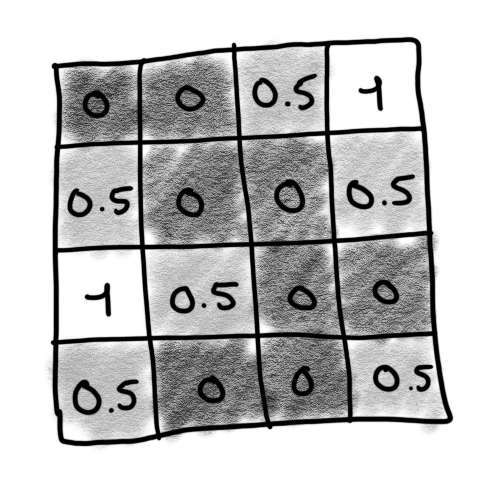

Sidenote: When you have a color image, usually this will be an RGB image. RGB stands for "Red", "Green" and "Blue". This means that every pixel actually contains 3 values, one for each color channel.

### What is a label?

In our case, every image slice corresponds to a label slice. This label slice is actually an image as well: it has the same size as the input image and it is made up of pixels containing intensity values between 0 and 1. The special thing about the label slice is that it actually *only* contains 0's and 1's. If a pixel contains a 1 in the label image, it is considered as the part of the object we want to segment. If it is 0, the pixel in the input image is not part of whatever we are trying to segment. 

In the following example the label shows which pixels are part of a street and which are not:

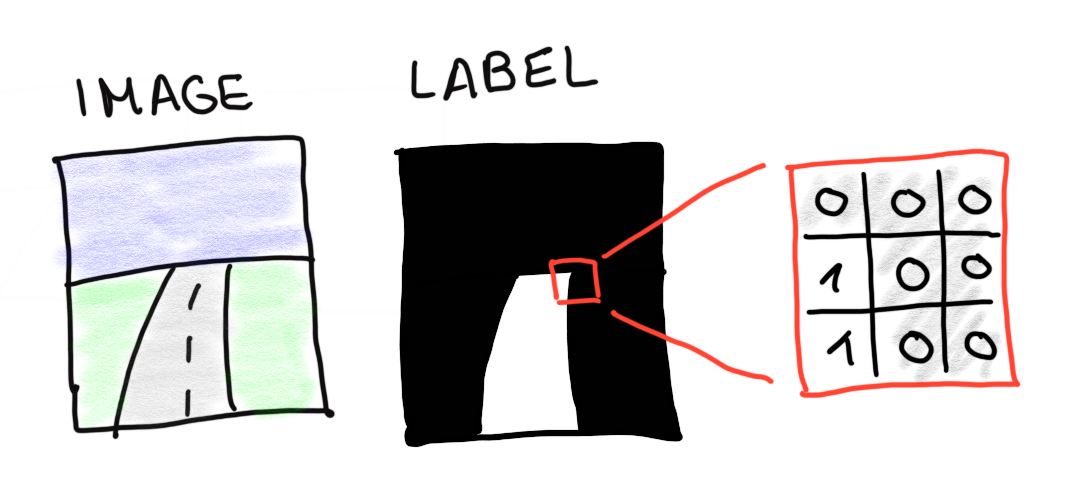

## A first look into the data

### Load the data into colab

The code below loads a single image slice and the labels object into our colab notebook.

In [4]:
# Location of the dataset in your drive
gdrive_path = '/content/gdrive/My Drive/dataset_doctoral_schools/'

# Load the labels
labels_file_name = 'labels.tif'

labels = np.array(io.imread(gdrive_path + labels_file_name))

# Load an example image
image_subdirectory = 'images/'
slice_index = 800
image_file_name = 'slice_'+ str(slice_index) +'.tif'

image = np.array(io.imread(gdrive_path + image_subdirectory + image_file_name))

### Dimensions of the input data

We have selected a single image slice and loaded it into the variable *image*. We have also loaded the label file into a variable *label*.

Lets check the shape of the label file and the image file. 

In [5]:
print(image.shape)

(1134, 1134)


We can see that our example image is a 2D image of 1134 x 1134 pixels.

What is the shape of the labels file? We are expecting this file to be 3D, with the first first dimension representing the slice index.

In [6]:
# FILL IN:
print(labels.shape)

(1004, 1134, 1134)


### Plotting the input data

Let's look at the contents of the example image and the corresponding label. 

To plot graphs and images we will use the library [matplotlib](https://matplotlib.org/). With this library, showing images is easy: using the functions **'matplotlib.pyplot.imshow()'** and **'matplotlib.pyplot.show()'**. 

However, 'matplotlib.pyplot' seems like a lot to type each time we want to plot something. Luckily we came prepared! Look at the cell with the imports (the second cell containing code in this notebook): we imported matplotlib.pyplot (**import matplotlib.pyplot**), but we also gave it an alias **plt** (**as plt**). This means we can use **plt.imshow()** and **plt.show()** instead!

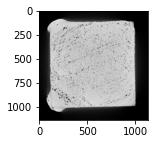

In [7]:
# Set the size of the plot
plt.figure(figsize=(2, 2))

plt.imshow(image, cmap='gray')
plt.show()

It seems like the size of this plot is a bit on the small side. Try out some different values of the figsize below. 

The parameter cmap specifies how the intensity values should be mapped to display colors. We recommend that you stick with gray for this lab, as this maps 0 to black and 1 to white, but have a look at all the other options for [cmaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html). Pick one and try it out in the code below. 

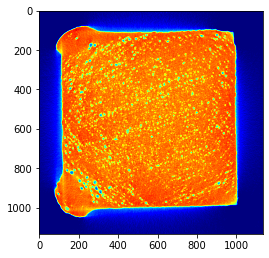

In [8]:
# FILL IN: different values for figsize (replace None)
plt.figure(figsize=(4,6))

# FILL IN: a different cmap (replace None)
plt.imshow(image, cmap='jet')
plt.show()

If we want to set all following plots to cmap gray (unless it is specified otherwise), i.e. to set the default colormap to gray, we can simply run the following line:

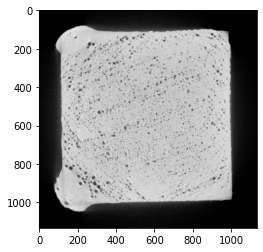

In [9]:
plt.gray()

plt.imshow(image)
plt.show()

Now let's have a look at the labels that correspond to this slice. Remember, *labels* is a 3D image, so you must first select the 2D slice of *labels* that corresponds to the example image. Indexing a dimensional object is done using [ ]. For example, if we want slice number 0 of labels, we would write **label_slice = labels[0]**. We call the number in between the square brackets the *index*. Such a data structure is called an *array* or a *list*. 

Important to note is that in nearly all programming languages, these structures start at index 0, and not at index 1! In the example below, the last element of the array has index 3, even though the length of the array is 4!



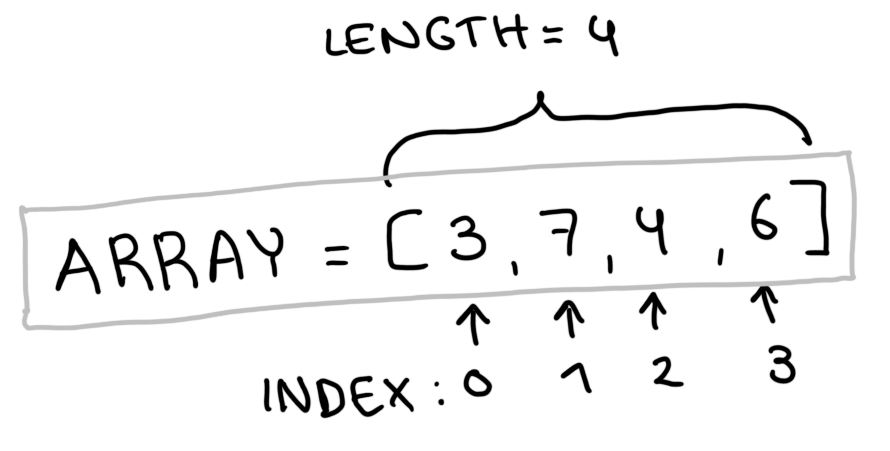



We chose a single slice number as an example and then saved this number into a variable. This means we can also grab a slice from labels by using this variable name like this: **label_slice = labels[*variable_name*]**. Find the name of this variable in a cell above (hint: it's the fourth cell) and fill it in below to allow the cell below to display its corresponding label slice. 

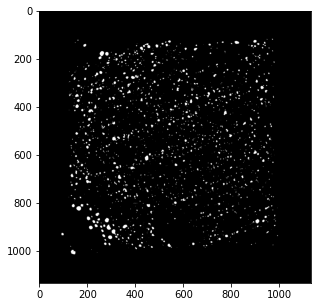

In [10]:
plt.figure(figsize=(5,5))

# FILL IN: the variable containing the index of the example image (replace None)
label_slice = labels[slice_index]
plt.imshow(label_slice)
plt.show()

It is also possible to plot multiple images on top of each other on the same plot. Let's plot the labels on top of the image. We'll make the example image gray and the labels yellow.

If you just plot two images on top of each other, the top one will completely cover up the bottom image, meaning the bottom image won't be visible anymore. We can deal with this by making the top image transparant to some degree. The transparancy degree is called the parameter **alpha** and is an optional parameter for the function **imshow()**. This parameter expects a value between 0 and 1 and it specifies how opaque the image is. A low value of alpha will make an image more transparant, revealing the image below. An alpha of value 1 will result in a completely opaque image, thereby covering up the image below.

Try out some different values of alpha in the code below and see how the resulting image changes.


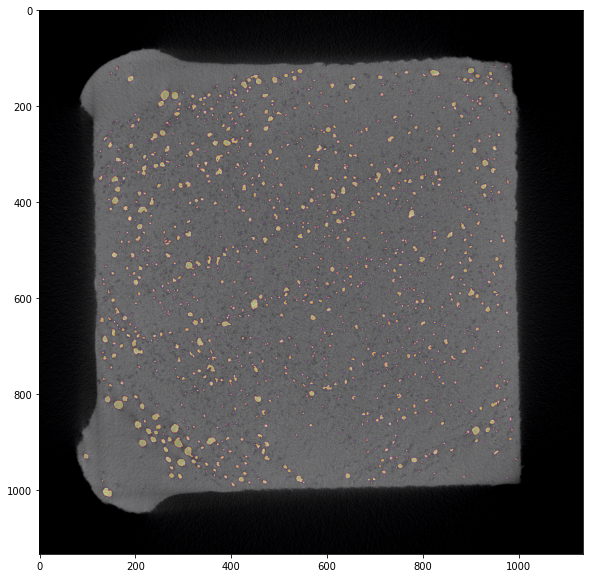

In [11]:
plt.figure(figsize=(10,10))

# FILL IN: try different values for alpha (replace None)
plt.imshow(image)
plt.imshow(label_slice, cmap='inferno', alpha = 0.5)
plt.show()

## Analyzing images


The 2D images consist of pixels which have their own intensity value. Let's take a look at the value of a random pixel location. We generate two random indices corresponding to the horizonal axis and the vertical axis respectively. Since the image is 2D, indexing once **image[row_index]** will result in a one dimensional line (a row) of the image. To get a specific pixel, we need to index twice by also specifying the column index: **image[row_index][column_index]**.



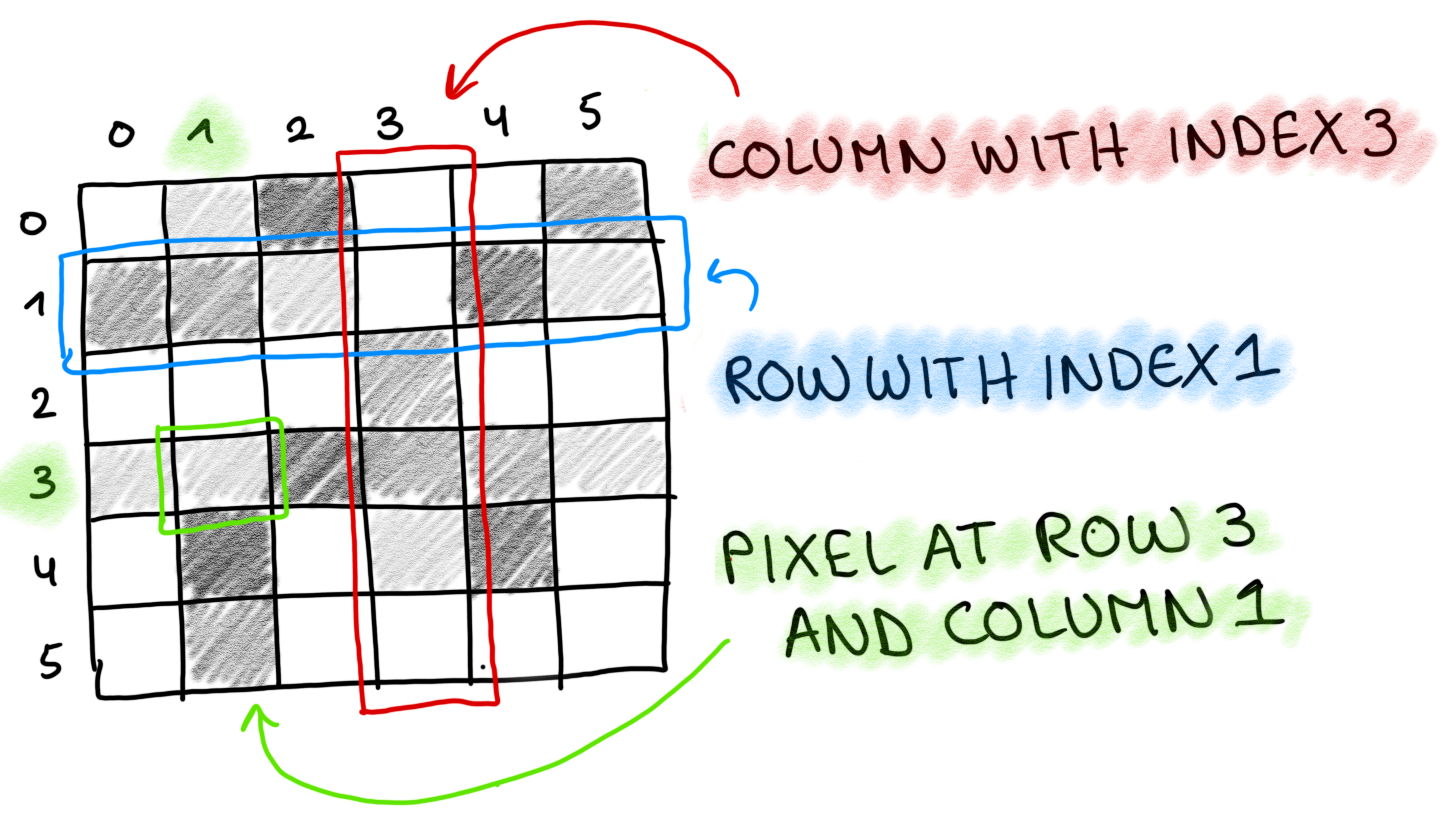

Run the code below a few times and make an assumption on what you think the minimum and maximum value of the image is.

In [12]:
row_index = random.randint(0, image.shape[0]) #Generate random row index
column_index = random.randint(0, image.shape[1]) #Generate random column index

value = image[row_index,column_index]

print('The value of pixel (',row_index,',', column_index,') is', value)

The value of pixel ( 511 , 299 ) is 0.81484133


### Introduction to numpy

Numpy is a Python library used to analyze higher dimensional structures. By using **image = *np.array*(io.imread(...))** in one of the first cells we made sure that the loaded image is a numpy array. Here, **np** is used as an alias for numpy.

In the code below we check out a few simple features (minimum and mean intensity value) of the image using numpy. Try printing the maximum and median yourself! Look for how max and median are written in the documentation. You will find the maximum [here](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) (and also minimum and mean) and the median [here](https://numpy.org/doc/stable/reference/routines.statistics.html). 

In [13]:
print('The minimum value in the image is', np.min(image))

# FILL IN: now do the same for the maximum value (replace None)
print('The maximum value in the image is', np.max(image))

print('The mean value of the image is', np.mean(image))

# FILL IN: now try printing the MEDIAN value (replace None)
print('The median value of the image is', np.median(image))

The minimum value in the image is 0.0
The maximum value in the image is 1.0
The mean value of the image is 0.49442697
The median value of the image is 0.71296877


Using numpy you can also easily extract subsections from a higher dimensional structure. If we extract all pixels between row 400-800 and column 400-800, we will be left with a subsection that is roughly in the middle of the image.

Selecting a single index was done using **image[index]**. Selecting a range of indices can be done using the ':' operator image**[index_start:index_end]**.

When using numpy to select a range of of multidimensional indices, a comma is used instead of closing and opening the square brackets. So for example you would not write image[10:20][10:20], but rather image[10:20,10:20]. This is only needed when using the range operator \:. When just accessing a single pixel you can still write it in the normal way image[10][17]. This takes some getting used to, but is quite powerful, as it allows you cut or crop parts (subsections) from an image!

Play around with the range indices and see what different subsections you get. What happens if you try to go outside the bounds of the image (i.e. indices higher than 1134 x 1134)?

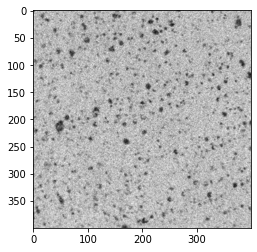

In [14]:
# FILL IN: see what happens when you try out different values 
subsection = image[400:800,400:800]

plt.imshow(subsection)
plt.show()

We can now do the same operations on this subsection as we did on the full image.

In [15]:
print('The minimum value in the image is', np.min(subsection))

print('The mean value of the image is', np.mean(subsection))

The minimum value in the image is 0.18469638
The mean value of the image is 0.75561684


### Higher level intensity value analysis

Histograms are a useful tool to analyze the distribution of intensity values in an image.

(array([2.3837e+05, 2.1770e+04, 2.1437e+04, 2.1164e+04, 2.0474e+04,
        1.8737e+04, 1.7081e+04, 1.5153e+04, 1.3410e+04, 1.1422e+04,
        9.8670e+03, 8.5610e+03, 7.5430e+03, 6.5300e+03, 5.7750e+03,
        5.2470e+03, 4.7360e+03, 4.3310e+03, 3.9270e+03, 3.7970e+03,
        3.4230e+03, 3.0920e+03, 2.8180e+03, 2.5640e+03, 2.3750e+03,
        2.1580e+03, 1.9730e+03, 1.8750e+03, 1.6560e+03, 1.5690e+03,
        1.5010e+03, 1.5460e+03, 1.4800e+03, 1.3610e+03, 1.3750e+03,
        1.3480e+03, 1.3360e+03, 1.3980e+03, 1.3760e+03, 1.3960e+03,
        1.4500e+03, 1.3660e+03, 1.5820e+03, 1.5260e+03, 1.4340e+03,
        1.6190e+03, 1.6630e+03, 1.7280e+03, 1.7050e+03, 1.8290e+03,
        1.9550e+03, 2.0070e+03, 2.1260e+03, 2.2110e+03, 2.2990e+03,
        2.4770e+03, 2.7650e+03, 3.0020e+03, 3.1640e+03, 3.4390e+03,
        3.8240e+03, 4.3660e+03, 4.7990e+03, 5.4700e+03, 6.5150e+03,
        7.5470e+03, 8.9420e+03, 1.0684e+04, 1.2845e+04, 1.5431e+04,
        1.8217e+04, 2.1694e+04, 2.5529e+04, 2.90

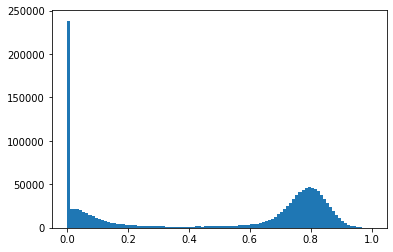

In [16]:
plt.hist(image.ravel(), 100)

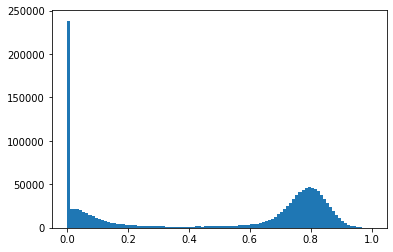

In [17]:
# The matplotlib hist function works better with 1D arrays than 2D arrays
# so using flatten, we can get a (very long) 1D array representing the original image
flat_image = image.flatten()


# bins specifies the number sections you want te split the whole range into. 
# Splitting range the intensity range 0-1 into 100 bins will result in bins (0.00-0.01),(0.01-0.02),...
plt.hist(flat_image,bins=100)
plt.show()

On the x-axis of the image there are pixel values. The y-axis shows how many pixels of the image have a certain pixel value.

Knowing that light pixels have a higher intensity value and dark pixels have a lower intensity value, what does the peak in the histogram at 0.0 represent in the image? What does the bump around 0.8 represent?

Using the numpy **where** function, we can create a new image of which the values are based on conditions applied to the original image. [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) is used in the following manner:

**resulting_image = np.where(condition on original image, value if condition is true, value if condition is false)**

In the code below, we attempt to create an image (called a mask) to separate (segment) the background from the object in an image. We try to set background pixels to 0 and foreground pixels (metal and pores) to 1. We attempt to create this mask by setting all pixels that are 0.0 in the original image to 0 in the mask, and all other pixels to 1.

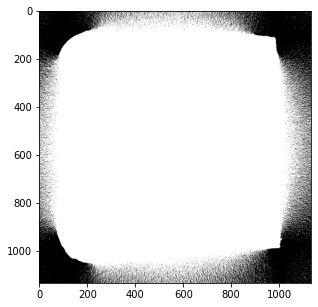

In [18]:
background_threshold = 0.0

plt.figure(figsize=(5,5))
mask = np.where(image > background_threshold, 1, 0)
plt.imshow(mask)
plt.show()

This mask is clearly not extracting the background very well. It seems that there are background pixels that have a higher value than 0.0. Try to find a better value for the threshold to remove the background. 

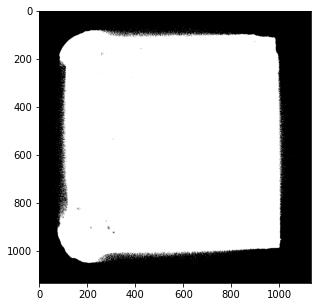

In [19]:
# FILL IN different threshold values (replace None)
background_threshold = 0.2

plt.figure(figsize=(5,5))
mask = np.where(image > background_threshold, 1, 0)
plt.imshow(mask)
plt.show()

You will notice that it is not really possible to extract non-background pixels without losing any pore-pixels. This means that the intensity value range of the object pixels overlaps with intensity value range of the background pixels.

Now try to extract ONLY the pores as best as you can using thresholding. Do this by changing the parameters upper_threshold and lower_threshold. The second plot will show the pixels that have been extracted using your threshold values. 

Note that there are two different **where** statements in the following code.

* mask = np.where(lower_threshold < image, 1, 0)
* mask = np.where(upper_threshold > image, mask, 0)

The first type is like what we saw before. It means: put a value of 1 at every pixel of the image that is above the lower_threshold. 

In the second type, it is specified that we want to set a value of "mask" at every pixel of the image that is under the upper threshold. This is another convenient numpy tool. These values that are passed to the where functions can either be a scalar (like 1 or 0) OR they can be a higher dimensional structure that has **the same dimension** as the array that the where function is performed on. In this case, **image** and **mask** have the same dimension (which is logical as the mask was first created by using the where function on image), so it is clear to numpy that the pixels have a one-on-one mapping, each pixel value corresponds to a mask value. For example, in the second example of the where statement, if the condition is fulfilled at a certain index **lower_threshold < image[10][20]**, then it will put take the value corresponding to the same index in mask, **mask[10][20]** as the new pixel value at [10][20].



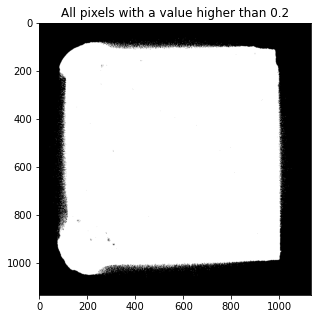

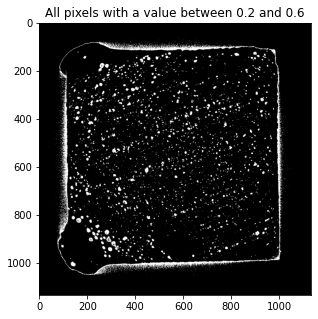

In [20]:
# FILL IN: play around with these values (replace None)
upper_threshold = 0.6
lower_threshold = 0.2

# Do not change the rest of this cell
mask = np.where(lower_threshold < image, 1, 0)
plt.figure(figsize=(5,5))
plt.imshow(mask)
plt.title("All pixels with a value higher than " + str(lower_threshold))
plt.show()

mask = np.where(upper_threshold > image, mask, 0)
plt.figure(figsize=(5,5))
plt.imshow(mask)
plt.title("All pixels with a value between " + str(lower_threshold) + " and " + str(upper_threshold))
plt.show()





And just like that, you have a first segmentation! You tried looking for the best threshold values by showing the resulting mask and choosing that values that resulted in the best visual segmentation. Of course, visual validation is not very scientific, so next we will look at more thorough and objective ways of validation.

## Validation



### Functions

Soon you will learn how to numerically validate by comparing a mask to the provided (ground truth) labels. This validation is something that we will use repeatedly during these session. To avoid having to copy and paste the validation code multiple times, we'll code it in our own *function*.

Below is a very simple function that takes in two variables (numbers), calculates the sum of those variables and returns the resulting value. There are some comments in the cell explaining what each line does. Be aware that the code placed below the define line are placed at an indentation (tab). This is typical Python syntax to indicate that they are part of the function that is being defined.


In [21]:
# The function signature looks like this: def function_name(input_variable1, input_variable2, ...)
# It always starts with 'def' (because you define the function)
# Then comes the function name, which you will use to call the function
# And then the input variables are in brackets. These are the variable the function needs to
# perform its task
def add(a, b):

  # Here the function calculates what it needs to. This is the block of code that you want to
  # be able to call multiple times
  result_value = a + b

  # The return statement gives an answer back the the line of code that called it
  return result_value

We can now call this function as many times as we want, using different input variables!

In [22]:
first_addition = add(4,9)
print(first_addition)

second_addition = add(47238,21903)
print(second_addition)

13
69141


Note that this "add" function is just an example. In practice, it is not very usefull since writing *a+b* is less work than writing *add(a,b)*!

### The IOU coefficient

One way to validate how well a segmented mask matches the given labels is the **Intersection Over Union** coefficient, or simply the **IOU**. As the name implies, it is the *intersection* of the labels and the segmented mask (meaning the number of pixels that are 1 in *both* the labels and the segmented mask) divided by the *union* of the labels and the segmented mask (or rather, the number of pixels that are 1 in *either* the labels or the mask).

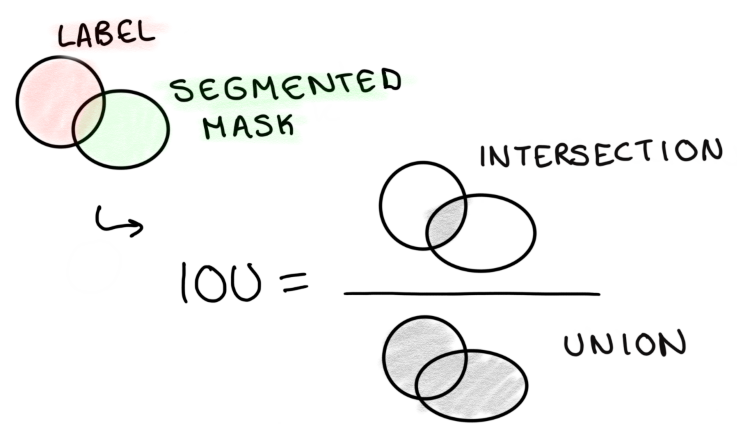

Below is a function that calculates the IOU of our problem. The first variable that it takes is the segmented mask that we created. The second variable is the labels corresponding to the mask. 

In [23]:
def IOU(masked, labeled):

  intersection = np.logical_and(masked, labeled)

  union = np.logical_or(masked, labeled)

  iou_score = np.sum(intersection) / np.sum(union)

  return iou_score

#def IOU(segmentation, groundtruth):
#  return (segmentation & groundtruth).sum()/(segmentation ^ groundtruth).sum()


Try to calcuate the IOU of your segmented mask below.

In [24]:
# FILL IN: the variables of the IOU function (replace None)
iou = IOU(mask, labels)

print("The IOU of our mask is:", iou)

The IOU of our mask is: 0.0043753955188682615


To find a better threshold values for this segmentation task, it would be nice to loop over a range of values for the upper or lower threshold, to evaluate their performance in producing different masks. The first step in doing this is to write a function to segment an image based on a given upper and lower threshold. In the cell below, the code that we want to have executed **within** the function is given.

In [ ]:
mask = np.where(lower_threshold < image, 1, 0)
mask = np.where(upper_threshold > image, mask, 0)

Now write your own function. Call your function **"threshold_segment"**. Make sure that the function accepts the **three input variables** that it needs to execute the code in the cell above. Note that these variables need to be in the correct order to ensure that the function call at the end of the cell works! Paste the code above within the function. Do not forget to **return** the segmented mask that was calculated. 

If you did this correctly, the code at the bottom of the cell should run.

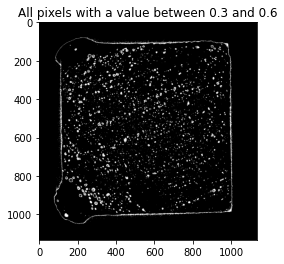

In [ ]:
# FILL IN: make a function to segment based on an upper and lower threshold
def threshold_segment(image, lower_threshold, upper_threshold):
  mask = np.where(lower_threshold < image, 1, 0)

  # A return statement
  return np.where(upper_threshold > image, mask, 0)

# Do not change the rest of this cell. It is to test your function:
upper = 0.6
lower = 0.3

mask = threshold_segment(image, lower, upper)

plt.imshow(mask)
plt.title("All pixels with a value between " + str(lower) + " and " + str(upper))
plt.show()



## For loops

To find the best value for the thresholds, we need to execute the same function multiple times for different threshold values. So, we would like to loop over multiple values, executing the same code using different values for the threshold. 

**For loops** are a great tool to loop over multiple values or just execute code a certain number of times. There are different ways to use for loops, of which we have given some examples below. 

A for loop is written as follows: *for   loop_variable_name   in   an_array_of_things*. The syntax of for loops in Python is actually quite smart and can literally be translated to English. For example: *for fruit in my_bag_of_fruit* will do exactly what you expect it to do: loop over every piece of fruit in your bag of fruit.

In the following example, we loop over each word in an array of words and print the current word. 

In [ ]:
for word in ['Hi!','How','are','you?']:
  print(word)

Hi!
How
are
you?


We can also define an array beforehand and then loop over the elements in the array:

In [ ]:
array_1D = [10,3,6,18]

for value in array_1D:
  print(value)

10
3
6
18


Another fun thing you can do with for-loops is nesting them within eachother! In the code below we create a 2D array (like an image), then first loop over the rows of this 2D array, which are 1D array-objects. We can then loop over these 1D rows using another for loop.

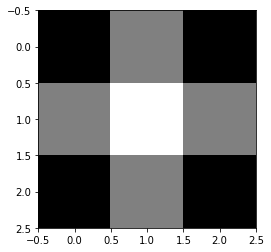

The row is: [1, 2, 1]
1
2
1
The row is: [2, 3, 2]
2
3
2
The row is: [1, 2, 1]
1
2
1


In [ ]:
array_2D = [[1,2,1],[2,3,2],[1,2,1]]

plt.imshow(array_2D)
plt.show()

for row in array_2D:
  print('The row is:',row)
  for value in row:
    print(value)

It's usually more convenient to generate the array of values we wish to loop over rather than writing out every single value. The range function is commonly used to accomplish this. The range function in Python accepts either one, two or three parameters. 

If the range parameter receives only one parameter, it will generate an array with all integer values between 0 and the specified value (not including the specified value itself).

In [ ]:
# The square brackets and the * are needed to transform the range object to an array object.
# You will see that these [] and * are not needed when using a for loop, because the for 
# loop tool automatically creates the array for you
array = [*range(10)]
print(array)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


If the range parameter receives two parameters, it will generate an array with all integers between both of these values (excluding the second value (the maximum)).

In [ ]:
array = [*range(5,15)]
print(array)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


If the range parameter gets 3 parameters, the first two specify the minimum and maximum, and the third specifies the step size. So with a step size of two, the integers inbetween the minimum and maximum will increment with 2 instead of 1.

In [ ]:
array = [*range(0,100,10)]
print(array)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


Now if we combine this with a for loop we get:

In [ ]:
for value in range(5,10):
  print(value)

5
6
7
8
9


The range parameter can only take in integer values. If we want to loop over non-integer values, we need a workaround. Say we want all values between 0 and 1.6 in steps of 0.2. We can give the range function the values (0,16,2) and then just divide the value by 10!

In [ ]:
for integer_value in range(0,16,2):
  decimal_value = integer_value / 10
  print("The original value was ", integer_value, "and we change it to", decimal_value)

The original value was  0 and we change it to 0.0
The original value was  2 and we change it to 0.2
The original value was  4 and we change it to 0.4
The original value was  6 and we change it to 0.6
The original value was  8 and we change it to 0.8
The original value was  10 and we change it to 1.0
The original value was  12 and we change it to 1.2
The original value was  14 and we change it to 1.4


Alright, you finally have all the information you need to automate the search for better threshold values. 

With the lower threshold set at 0.30, we will search for an optimal upper threshold. Fill in the code below such that you loop over the values **0.30 to 1.00** (not including 1.00) **in steps of 0.05**. 

In [ ]:
lower_thr = 0.3

# FILL IN: The integer range values (replace None)
for integer_upper_thr in range(30,100,5):

  # FILL IN: the division to change the integer value to the sought after decimal value (replace None)
  decimal_upper_thr = integer_upper_thr/100

  mask = threshold_segment(image, lower_thr, decimal_upper_thr)

  iou = IOU(mask, label_slice)

  print("The iou for upper threshold", decimal_upper_thr, "is",iou)

The iou for upper threshold 0.3 is 0.0
The iou for upper threshold 0.35 is 0.07853801805721745
The iou for upper threshold 0.4 is 0.18344188886627316
The iou for upper threshold 0.45 is 0.3115201090661213
The iou for upper threshold 0.5 is 0.4559025914954165
The iou for upper threshold 0.55 is 0.5498291269554881
The iou for upper threshold 0.6 is 0.4981584421784947
The iou for upper threshold 0.65 is 0.36150829562594267
The iou for upper threshold 0.7 is 0.21737620718341955
The iou for upper threshold 0.75 is 0.11308133082008044
The iou for upper threshold 0.8 is 0.06246518974188454
The iou for upper threshold 0.85 is 0.04386871349382186
The iou for upper threshold 0.9 is 0.03845164855830305
The iou for upper threshold 0.95 is 0.03742394001611158


From these values, we can see that upper threshold 0.55 gives the best IOU. But if we loop over many more values, it will be hard to find the best value in all of our print statements. This is where one of the most imortant programming tools comes in: the if-statement.

### If statements

An if statement executes the code within it, if its **condition** is true. 

In [ ]:
if 10 > 4:
  print("The statement is True!")

The statement is True!


It can also be combined with an else-statement. The code within the else-statement is executed if the condition in the preceding if-statement is false.

In [ ]:
if 10 < 4:
  print("The statement is True!")
else:
  print("The statement is False!")

The statement is False!


We can use these if statements to keep track of the best threshold value! The principle works like this: 

*   Keep track 2 variables: the best IOU and the threshold value corresponding to this best IOU
*   Loop over different threshold values: if we find a better IOU, put this IOU in the best IOU variable and the corresponding threshold value in the best threshold variable.

Try to fill in the if condition below such that the best IOU is found.

In [ ]:
lower_thr = 0.30

best_IOU = 0
best_upper_thr = 0


for integer_upper_thr in range(30,100):

  decimal_upper_thr = integer_upper_thr / 100

  mask = threshold_segment(image, lower_thr, decimal_upper_thr)

  iou = IOU(mask, label_slice)

  # FILL IN: the condition in this if-statement (replace None)
  if iou > best_IOU:
    # FILL IN: set the best_IOU variable to the better iou that was just found (replace None)
    best_IOU = iou
    # FILL IN: set the best_upper_thr variable to the better decimal_upper_thr that was just found (replace None)
    best_upper_thr = decimal_upper_thr

print("The best upper threshold value is", best_upper_thr, "which gives an IOU of",best_IOU)

The best upper threshold value is 0.56 which gives an IOU of 0.552897373130644


Using the variables **lower_thr** and **best_upper_thr**, create the mask by using the **threshold_segment** function you wrote earlier: create and plot the mask using the imshow and show functions of plt.

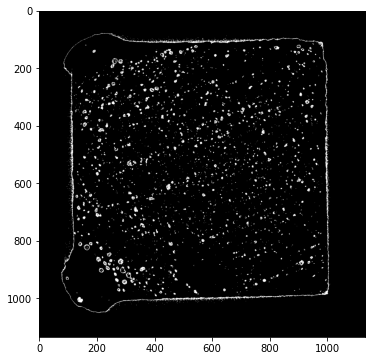

In [ ]:
plt.figure(figsize=(6,6))

# FILL IN: use the threshold_segment() function to create the mask (replace None)
mask = threshold_segment(image, lower_thr, best_upper_thr)

# FILL IN: plot the mask (replace None)
plt.imshow(mask)
plt.show()

## Edges and thresholding: Sobel and hysteresis thresholding

A major issue in the previous steps is the fact that the edge of the metal is also detected as "pores" by our simple methodology. Let's try to remove the edge using edge detection! 

The idea is as follows:


1. Detect the edges of the metal
2. Fill in everything within these edges, creating a mask metal-vs-background
3. Remove all background information from the original image using this mask


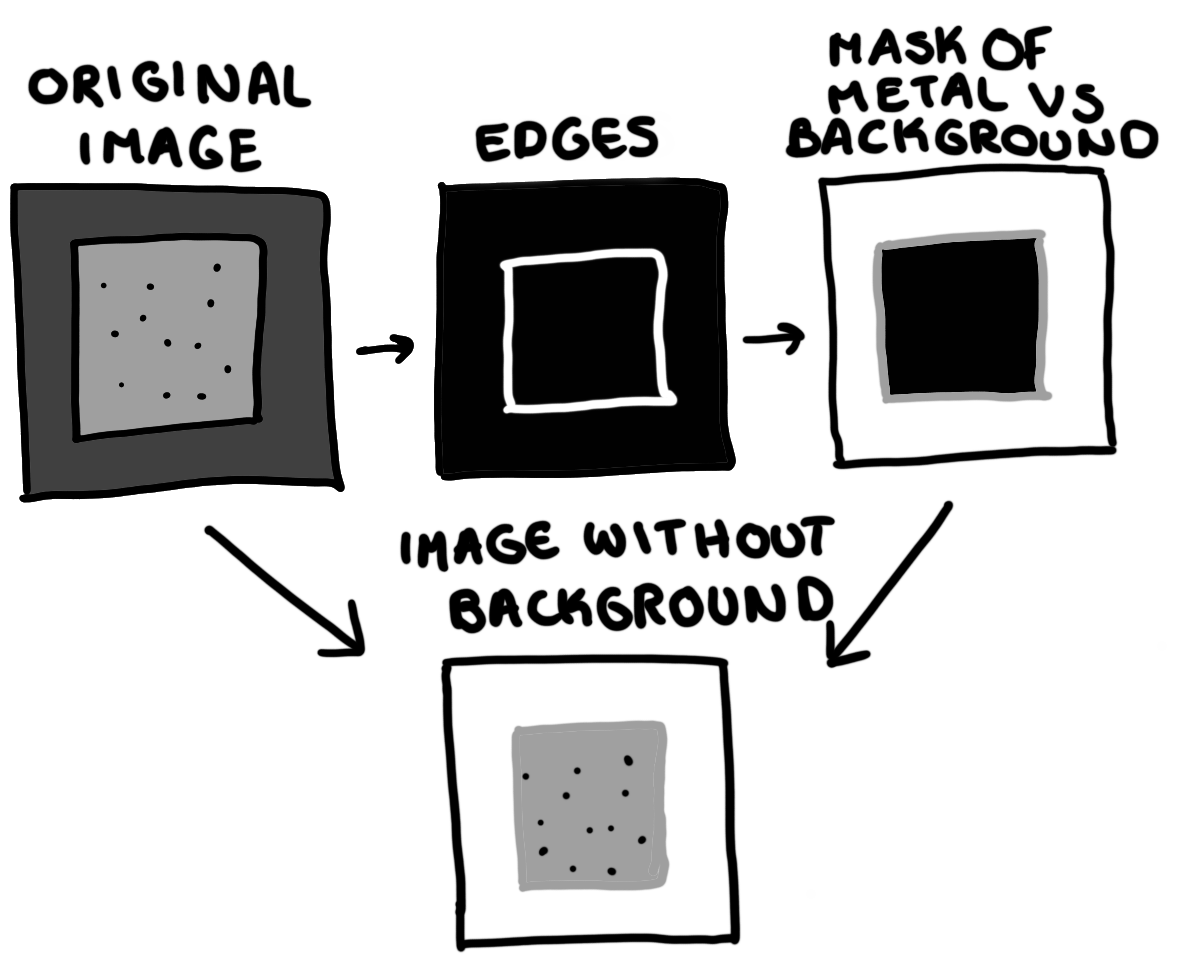

There are different edge detecting algorithms in literature (https://en.wikipedia.org/wiki/Edge_detection). In this example we will be using the Sobel operator. Luckily, we don't have to program this algorithm as the import skimage.filters has this Sobel operator built-in as a Python function. 

Try it out:

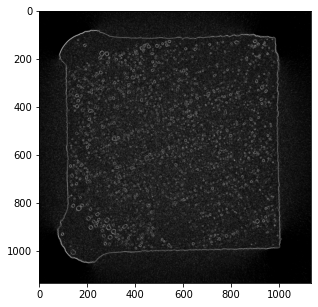

In [ ]:
plt.figure(figsize=(5,5))

edges = filters.sobel(image)

plt.imshow(edges)
plt.show()

Well... that didn't really work too well did it? The edges of the pores are also seen as edges. We need a way to filter out the really clear outer edge. For this we can use **hysteresis thresholding**. 

The scikit-image documentation gives hysteresis thresholding the following definition: *In the context of thresholding, it means that areas above some low threshold are considered to be above the threshold if they are also connected to areas above a higher, more stringent, threshold. They can thus be seen as continuations of these high-confidence areas.*

Rather than only considering the pixel value as a feature-of-interest, the hysteresis thresholding approach thus additionally considers the neighboring pixel values as features when classifying an individual pixel.

Finding the optimal values for the high and low parameters can be quite a challenge. For the sake of this assignment, we have already determined that the values low = 0.08 and high = 0.4 work well. 

Try out some different values and see what changes. 

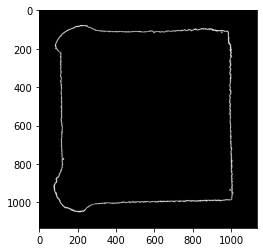

In [ ]:
# FILL IN: try different values for high and low (replace None)
low = 0.08
high = 0.4

# DO NOT CHANGE THIS CODE
# Lowt contains all sobel edge pixels about the "low" threshold
lowt = (edges > low).astype(int)
# Hight contains all sobel edge pixels about the "high" threshold
hight = (edges > high).astype(int)
# This line performs the hysteresis threshold
hyst = filters.apply_hysteresis_threshold(edges, low, high)

plt.imshow(hyst)

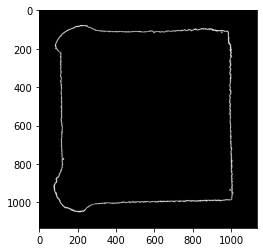

In [ ]:
# RUN THIS CODE AND DON'T CHANGE IT! 
# This will use optimal values for the hysteresis thresholding
low = 0.08
high = 0.4

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

plt.imshow(hyst)

Once the hyst variable contains the edges of the metal, we need a way to mask out foreground from background. For this, we basically work like the well known "fill" tool. You will probably be familiar with this from the Windows paint tool. You specify a startpoint and "fill" will color in around the startpoint, up until it reaches some defined edges.

Defining a starting point in our problem is very simple: we can just take the middle of the image.

**Question**: what would be a good option as a starting point if you wanted to fill the *background* and not the metal?

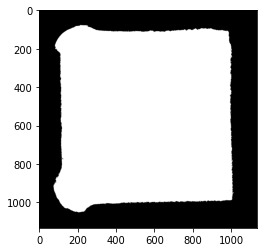

In [ ]:
# Define the starting point (middle of the image)
x = int(len(image)/2)
y = int(len(image[0])/2)

# Fill in with the value 1 starting from the middle point
filled = flood_fill(hyst, (x, y), 1)

plt.imshow(filled)
plt.show()

It's not really clear from this image but the "foreground" in this mask still cointain the edges we detected using sobel and hysteresis. This is just what we do not want: these were pixels that our thresholding algorithm was confusing with pores. 

To fixed this, we simple remove all the edge pixels that we found (stored in *hyst*) from the filled mask that we created.

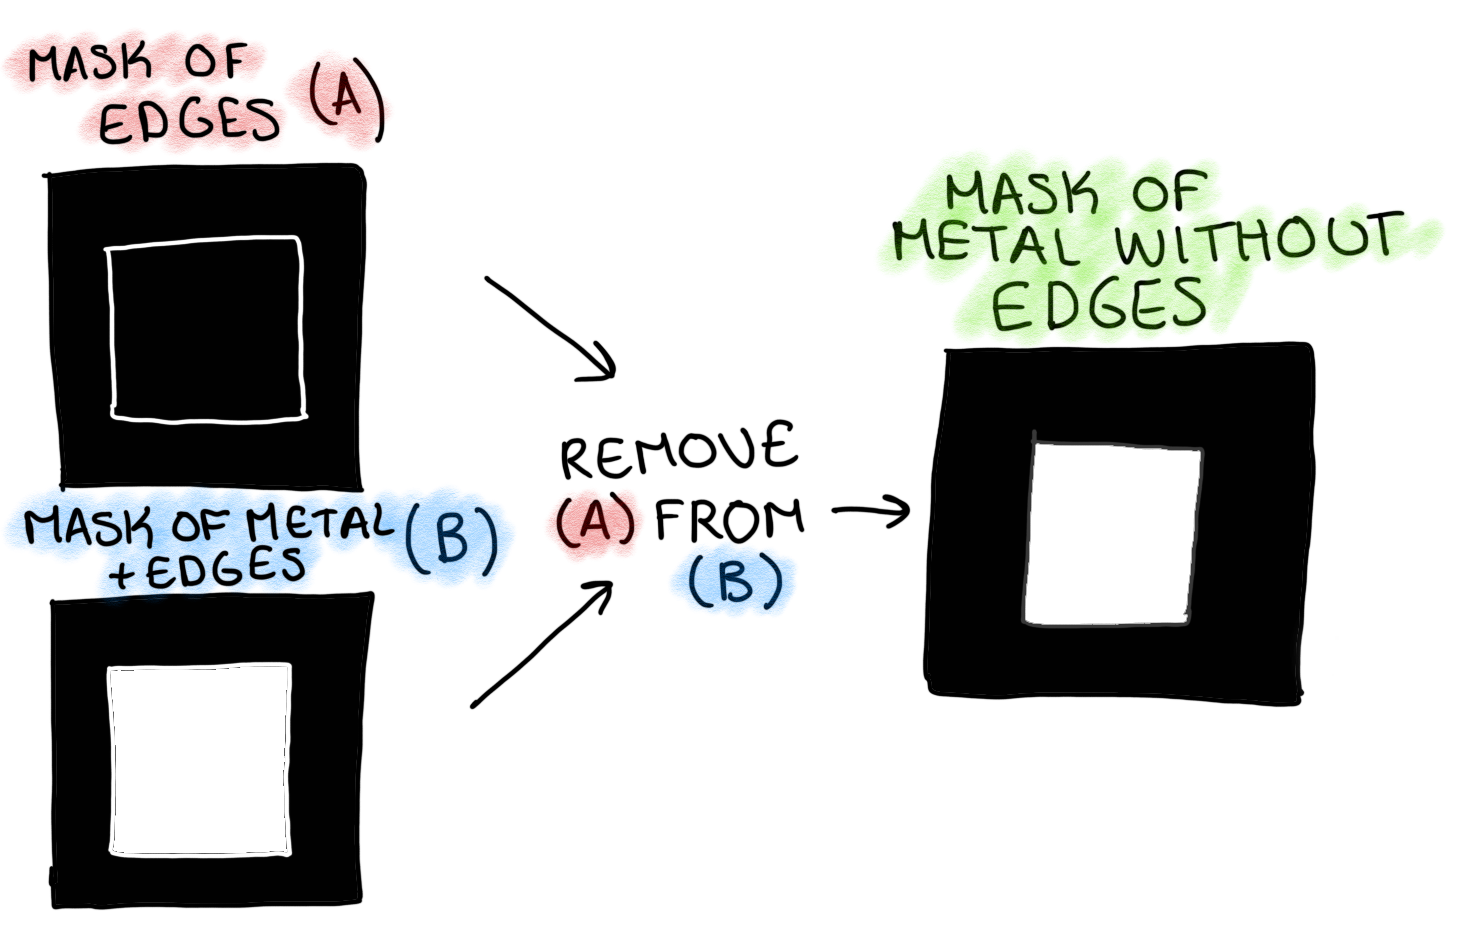

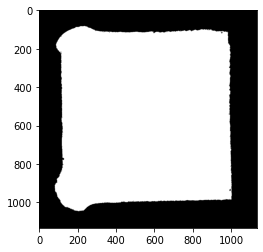

In [ ]:
# This code does the following: sets all pixels in "filled" to zero if they are not
# zero in "hyst" (which is where the edges are)
filled = np.where(hyst != 0, 0, filled)

plt.imshow(filled)

Alright great! Now we just have to set all pixels that are background in the filled image to background in our original image.

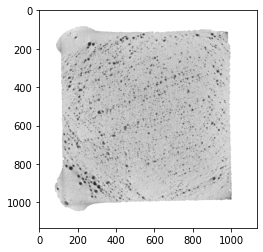

In [ ]:
without_background = np.where(filled,image,1)
plt.imshow(without_background)

Look at the code above and the image it generates. Why do you think we set the background pixels to 1 instead of 0?


Now it's your turn: write some code that determines the best threshold to extract all the pores from the image without the background. Note: we only need one threshold value this time!

To recap, you will need: 


1. A parameter to keep track of the best iou 
2. A parameter to keep track of the threshold value corresponding to the best iou
3. A for loop for the threshold value: try to go from 0.00 to 1.00 in steps of 0.01
4. A line that creates a mask from this threshold value (hint: the exact line that you need can be found in near the bottom of the cell)
5. A line that calculates the iou using the function IOU we created before
6. An if statement that looks for the best iou value and sets the two "best" variables

The best IOU found was: 0.7870946153202644


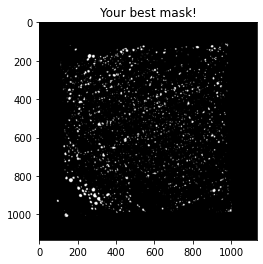

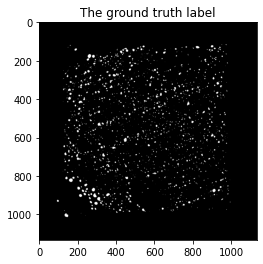

In [ ]:
best_iou = 0
best_thr = 0

# FILL IN: complete this code to find the best iou and threshold!
for i in np.arange(0,1,0.01):
  thr = i
  mask = np.where(without_background < thr, 1, 0)
  iou = IOU(mask, label_slice)
  if iou > best_iou:
    best_iou = iou
    best_thr = thr

# The following code is used to show the best threshold
print("The best IOU found was:",best_iou)
mask = np.where(without_background < best_thr, 1, 0)
plt.imshow(mask)
plt.title('Your best mask!')
plt.show()
plt.imshow(label_slice)
plt.title('The ground truth label')
plt.show()

## Filters and clustering

### Filters

Filters are a very powerful tool in image processing. In a general sense they create a new image where the pixel values in the new image are a function of the pixel values in the input image. Very often there is a one-to-one relation between a pixel in the output image and a pixel in the input image.  In the following example, we make a new image based on a 3x3 **kernel**. This means each output pixel value is a function of its corresponding input pixel value and the neighboring input pixel values in a 3x3 neighborhood. We will implement a mean, also known as an averaging, filter. Since sample averaging reduces the variance when applied to samples drawn from a symmetrically distributed random process, this is an effective noise filter in many imaging scenarios.

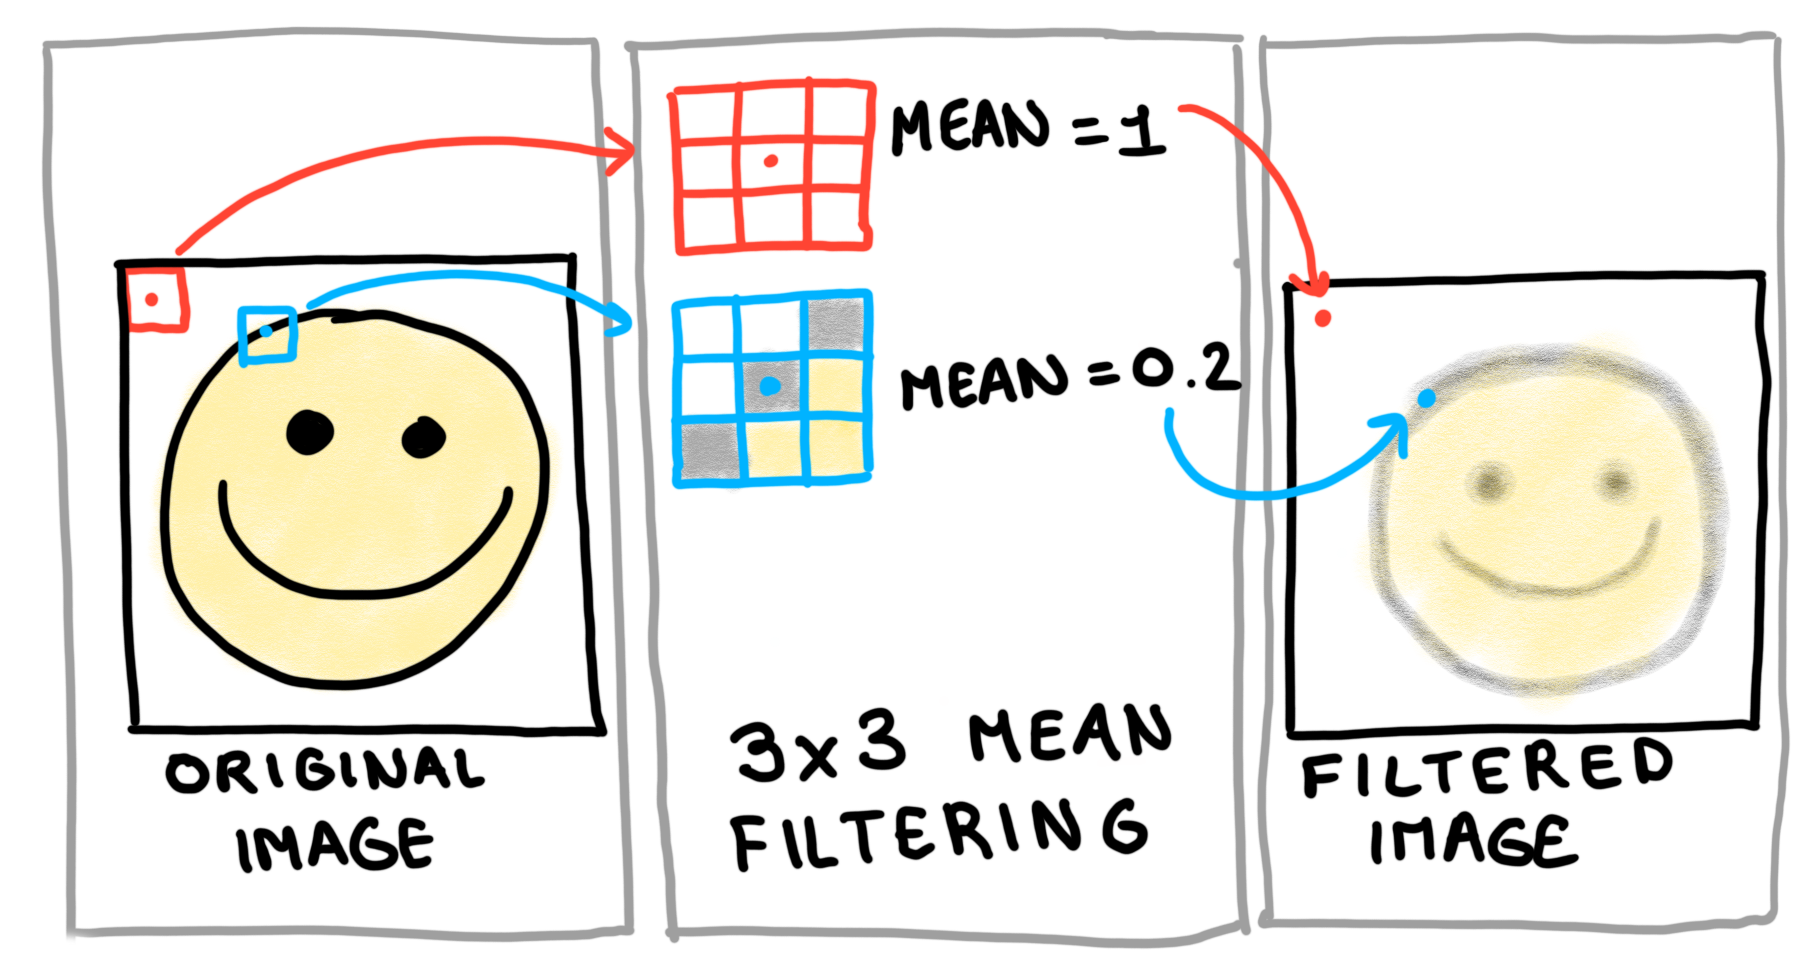

You can imagine a 3x3 kernel (or "structuring element") sliding over each pixel in the input image. For each position, it calculates a new value, the mean of the 9 pixels in the 3x3 kernel. This value is then used as the output value for that particular kernel position. 

Apart from reducing noise, this "average" operator will also result in a blurred image. This is exactly what the "blur" function of the OpenCv library does. What do you think will happen if you use a larger kernel? Will the resulting image be more or less blurred than when using a small kernel?

Try it out in the code below: play with the values of the kernel (the (NUMBER,NUMBER) parameter in blur). What happems if you choose a high value for one of the dimensions and a low value for the other?

NOTE: the dimensions of this kernel MUST be uneven! This is logical since the kernel needs to have a central pixel, which isn't posible with a kernel of even dimensions. 

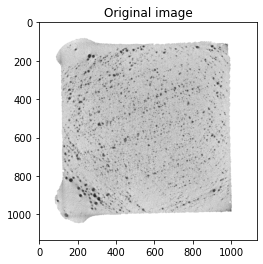

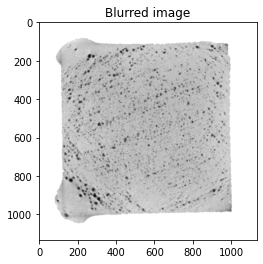

In [ ]:
# FILL IN: try out different kernel sizes
blurred_image = cv.blur(without_background, (5,5))


plt.imshow(without_background)
plt.title('Original image')
plt.show()
plt.imshow(blurred_image)
plt.title('Blurred image')
plt.show()

There are many more filters available. For example, you could take the maximum of the pixels in the area as the new value. The same goes for the minimum. These minimum and maximum operators are actually very popular filter operators! They are instances of what is called image erosion and dilation respectively.

The code below performs dilation. Try out some different kernel sizes!

Note that in the code below, a kernel object must first be made using **cv.getStructuringElement**. This is because the dilate function expects a kernel object instead of making it themselves based on size specifications.



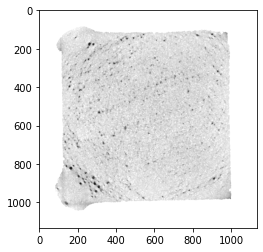

In [ ]:
# FILL IN: try out different sizes of the structuring element
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))

max_image = cv.dilate(without_background,kernel)
plt.imshow(max_image)

Now do the same but now for the *erode* function:

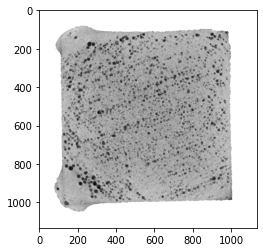

In [ ]:
# FILL IN: complete this code
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))

min_image = cv.erode(without_background, kernel)
plt.imshow(min_image)

For an extended introduction to erosion and dilation and other so-called morphological operators, we refer you to this [website](https://towardsdatascience.com/understanding-morphological-image-processing-and-its-operations-7bcf1ed11756). 

We now have 3 new images (dilated, eroded and blurred), each containing per-pixel features about the original image: the average, maximum and minimum of the surrounding pixels. Next we'll investigate using machine learning to use these features to automatically detect different structures in the image!

### Unsupervised learning: clustering

Clustering algorithms are a type of unsupervised machine learning tasks. They group input data into a pre-defined number of clusters. The intention is to have similar datapoints grouped into the same cluster. 

Say we have an image and for each pixel in that image, we have 2 filter values: the mean value and the maximum value (like the images blurred_image and max_image that we created before)

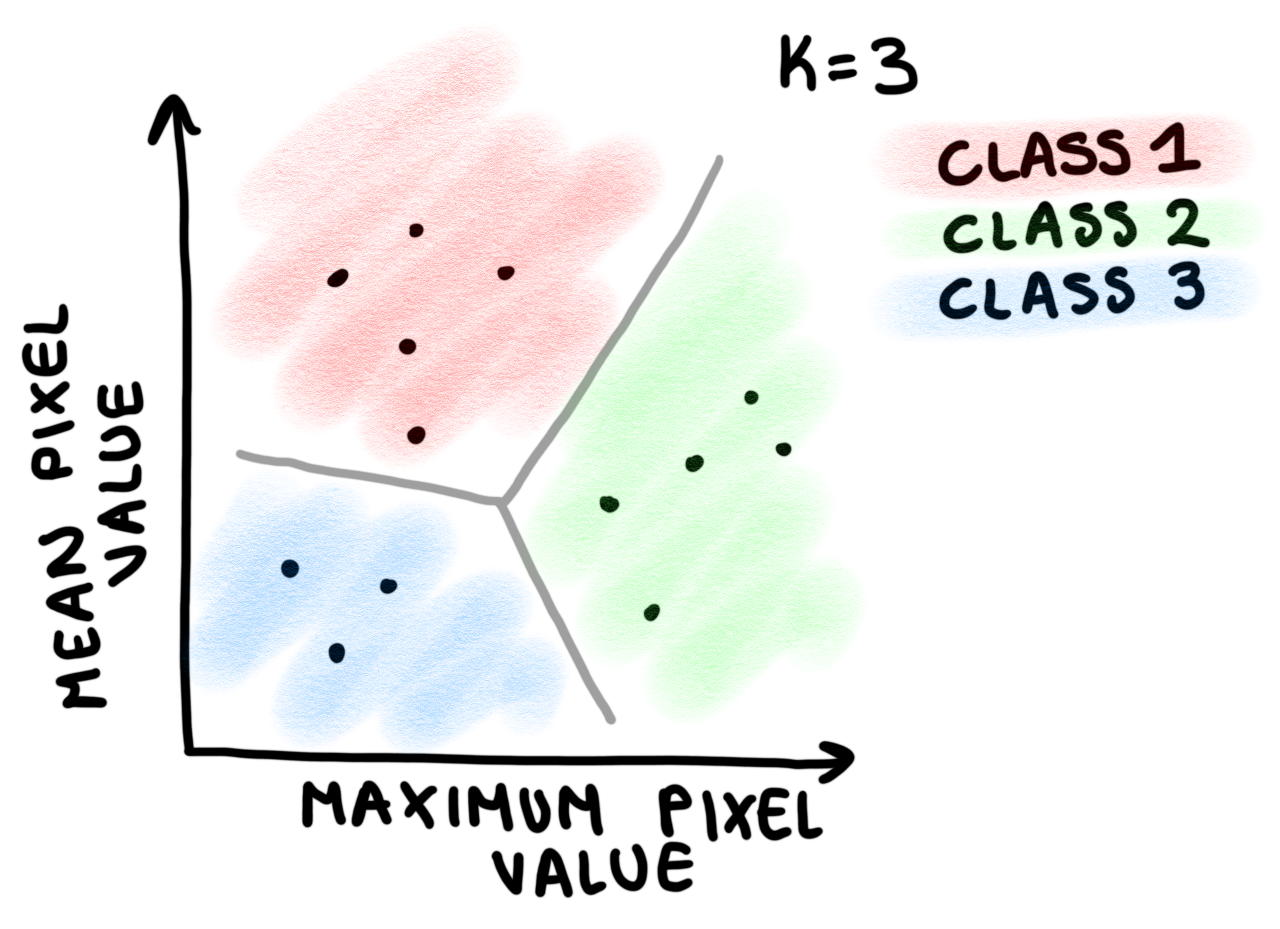

In the image above, each pixel is a dot on the graph. Pixels that lie close to eachother in the mean-vs-max graph, will be grouped into the same cluster. 

The number of classes needs to be specified by the user (that's us!). In this case, we chose three. 

If we want to cluster based on our three feature maps (blurred_image, max_image, min_image), we need to change the datastructure a bit. This is because the algorithm we will use expects the data to be in a certain format: it expects an array where every element in this array is a sample (a sample is in our case a pixel). Each sample element consists of features. 

In the following drawing: imagine the two "images" on the left are two of our feature maps: blurred_image and max_image.

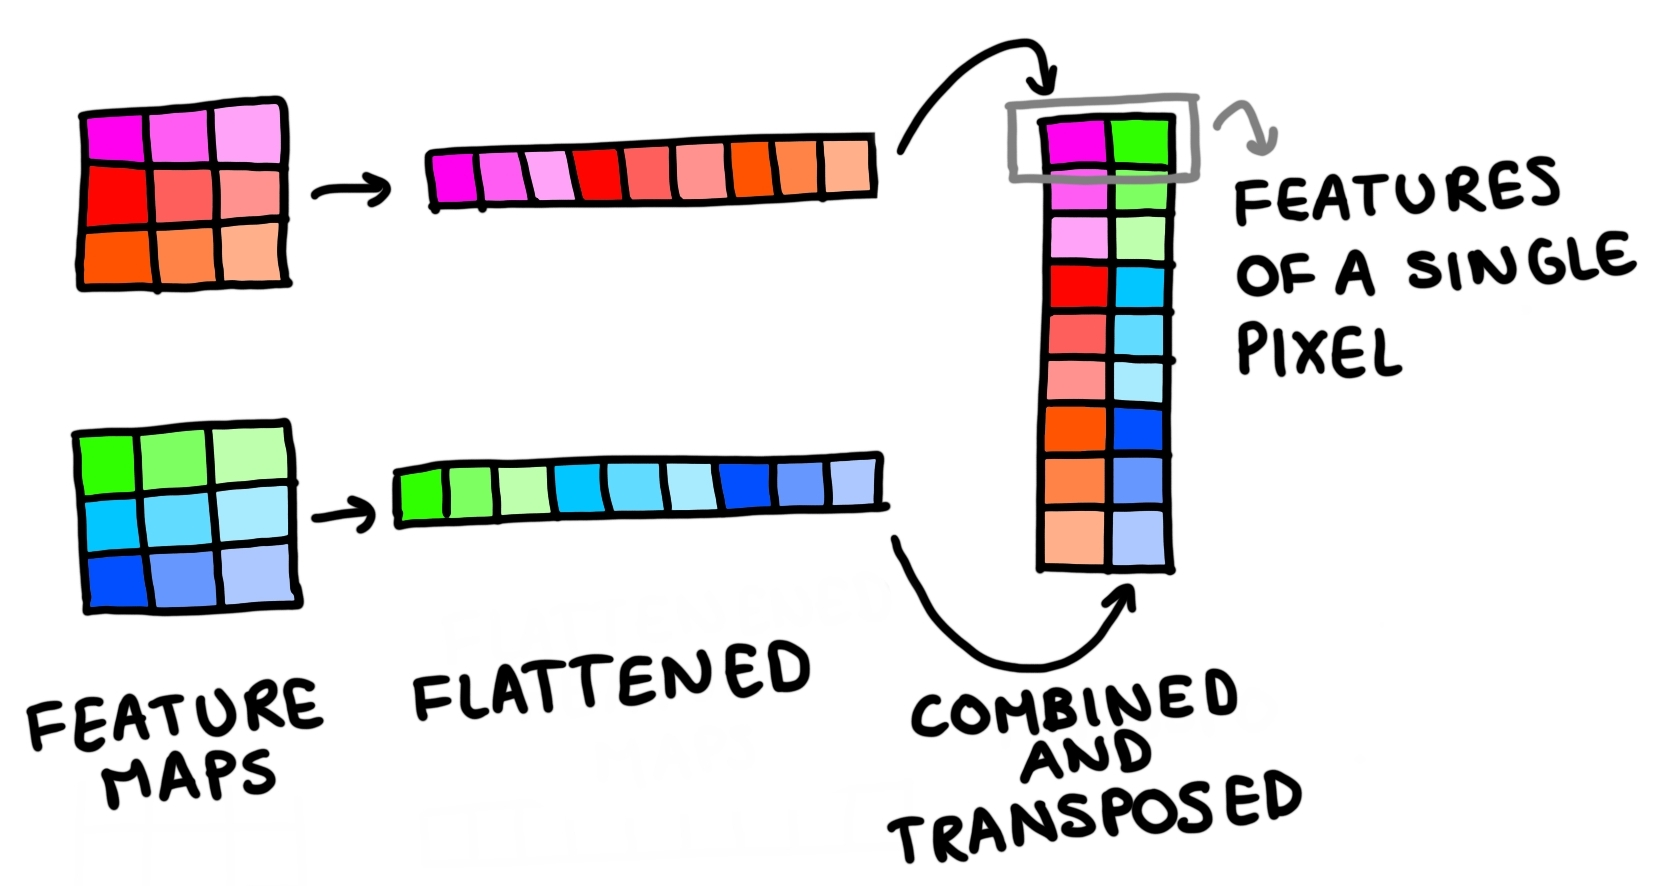

If we give this feature array to a cluster algorithm and specify that we want 3 clusteres, a posible division could look like this:

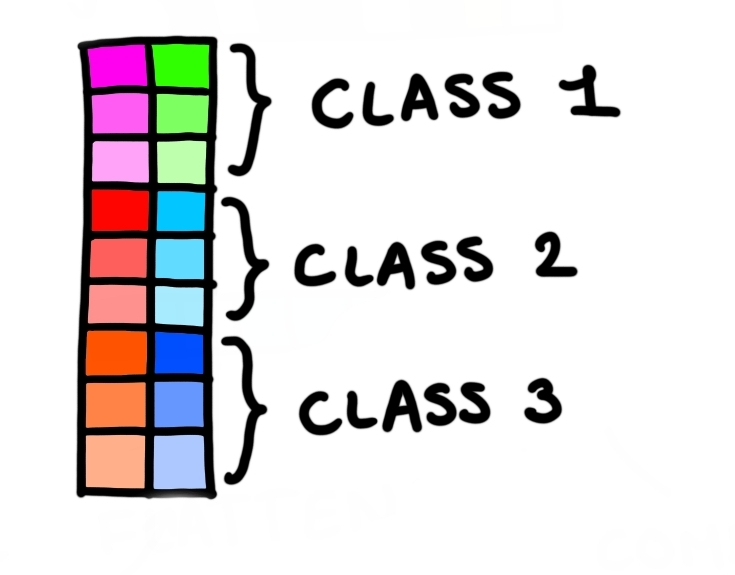

In the code below, we transform our three feature maps blurred_image, max_image and min_image into an array of samples.

In [ ]:
all_features = np.empty((3,len(blurred_image.flatten()))) #First create an empty arra with 3 columns, and the length of one of the three feature maps (blurred.image)
all_features[0] = blurred_image.flatten()
all_features[1] = max_image.flatten()
all_features[2] = min_image.flatten()
all_features = np.transpose(all_features)

print("The shape of our feature array is", all_features.shape)
print("This means that we have", all_features.shape[0], "samples (or rather, pixels), where each sample has",all_features.shape[1],"features")

The shape of our feature array is (1285956, 3)
This means that we have 1285956 samples (or rather, pixels), where each sample has 3 features


Now let's perform the k-means clustering algorithm. A detailed explanation on how this specific algorithm works can be found [here](https://towardsdatascience.com/k-means-clustering-explained-4528df86a120). First, we import the clustering algorithm:

Below is some code to cluster our array of features. Three clusters makes sense because we can cleary see 3 different structures in the image: background, metal and pores.

Play around with this value and see if you can find any other good clusters.

Note that this code takes a few seconds to run!


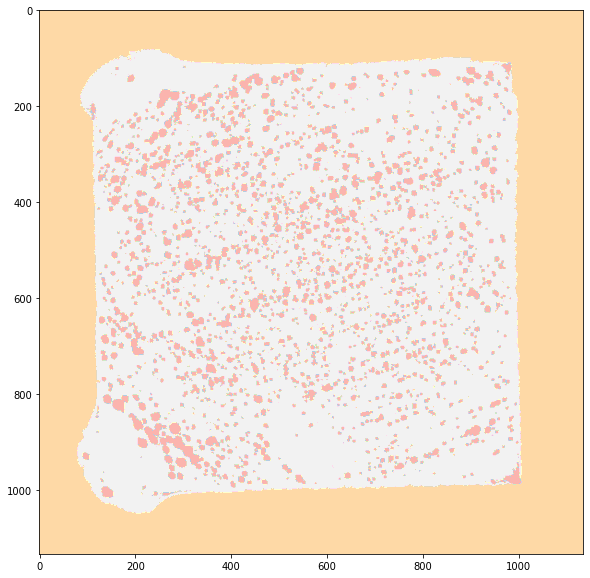

In [ ]:
# FILL IN: try different values for the number of clusters
number_of_clusters = 3

# This code calculates the centers of the clusters and then classifies all samples into a cluster
centroids, mean_dist = kmeans(all_features, number_of_clusters)
clusters, dist = vq(all_features, centroids)

# This code generates an image where the pixel values are the corresponding class number
plt.figure(figsize=(10,10))
clustered_image = clusters.reshape(image.shape)
plt.imshow(clustered_image,cmap='Pastel1')

The different colors in the resulting image represent the different classes that were found by the k-means clustering algorithm.

Through well-considered combination of the algorithms we've discussed today, like clustering, filtering, morphology, thresholding, looping and rigourous evaluation, a clever researcher can build and validate very powerful image analysis tools in their research.
That brings us to the end of the introduction to Python and basic segmentation in Python! We hope it was a fun and informative learning journey!

For those that have previous programming experience (or are just very fast learners), there is an additional optional exercise below!

### Advanced extra exercise: implement fill

In one of the previous steps, you were asked to use a fill function from skimage. Such an operation might seem evident, but in reality, it's more complex than it may look. 

Implement your own flood fill function. The function takes in three parameters: a 2D image (hyst) where edges are set as True and non-edges are set as False and two parameters representing the x and y coordinate of the starting point respectively. 

Be careful, making errors in code like this can cause you to use too much memory! This will cause your kernel to interrupt. If this happens, click "on runtime -> run before" to re-run all the previous cells.

In [ ]:
def fill(edge_image, start_point_x, start_point_y):
#1. If node is not Inside return.
#2. Set the node
#3. Perform Flood-fill one step to the south of node.
#4. Perform Flood-fill one step to the north of node
#5. Perform Flood-fill one step to the west of node
#6. Perform Flood-fill one step to the east of node
#7. Return.
  edge_image[start_point_x, start_point_y] = 1
  x = start_point_x
  y = start_point_y
 
  while edge_image[x, y] == 1:
    if edge_image[x+1, y] != 1:
      edge_image[x+1, y] = 1
      x = x + 1
    if edge_image[x-1, y] != 1:
      edge_image[x-1, y] = 1
      x = x - 1
    if edge_image[x, y+1] != 1:
      edge_image[x, y+1] = 1
      y = y + 1
    if edge_image[x, y-1] != 1:
      edge_image[x, y-1] = 1
      y = y - 1
  
  return 

result = fill(hyst, 600, 600)
plt.imshow(result)

KeyboardInterrupt: ignored

In [ ]:
hyst.shape

(1134, 1134)